In [1]:
import time
import cv2 as cv
import dlib
import numpy as np
from matplotlib import pyplot as plt

# Task 1

In [2]:
img_1 = cv.imread("assets/img_1.jpeg")
img_2 = cv.imread("assets/img_2.jpeg")
img_gray_1 = cv.cvtColor(img_1, cv.COLOR_BGR2GRAY)
img_gray_2 = cv.cvtColor(img_2, cv.COLOR_BGR2GRAY)

In [3]:
def show_images(images):
    plt.figure(figsize=(16, 8))
    count = len(images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        img = images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap=cmap)
    plt.show()
    
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

def get_points(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

### Face detection (with bounding box)

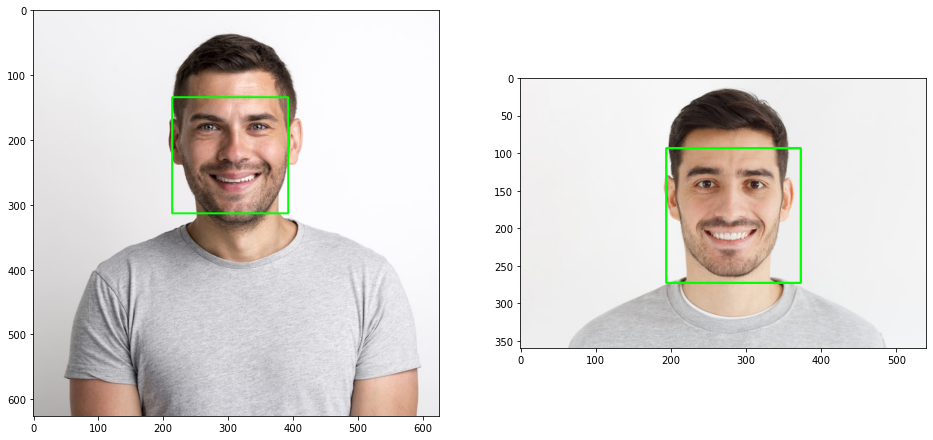

In [4]:
def detect_bboxes(img, img_gray):
    img_bbox = img.copy()
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_gray)
    
    for face in faces:
        (x, y, w, h) = rect_to_bb(face)
        cv.rectangle(img_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return img_bbox, faces
        
img_bbox_1, faces_1 = detect_bboxes(img_1, img_gray_1) 
img_bbox_2, faces_2 = detect_bboxes(img_2, img_gray_2) 

show_images([img_bbox_1, img_bbox_2])

### Face landmarks detection

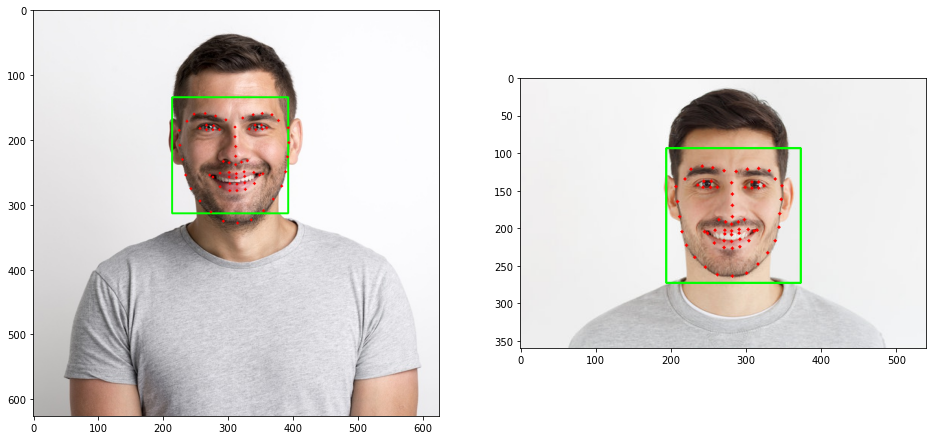

In [5]:
def detect_landmarks(img, img_gray, faces):
    img_landmark = img.copy()
    predictor = dlib.shape_predictor("assets/shape_predictor_68_face_landmarks.dat")
    
    points_list = []
    
    for bbox in faces:
        points = predictor(img_gray, bbox)
        points = get_points(points)

        for (x, y) in points:
            cv.circle(img_landmark, (x, y), 2, (0, 0, 255), -1)
            
        points_list.append(points)
    
    return img_landmark, points_list


img_landmark_1, points_list_1 = detect_landmarks(img_bbox_1, img_gray_1, faces_1)
img_landmark_2, points_list_2 = detect_landmarks(img_bbox_2, img_gray_2, faces_2)

show_images([img_landmark_1, img_landmark_2])

In [6]:
face_landmarks_1 = points_list_1[0]
face_landmarks_2 = points_list_2[0]

### Construct Delaunay triangulation

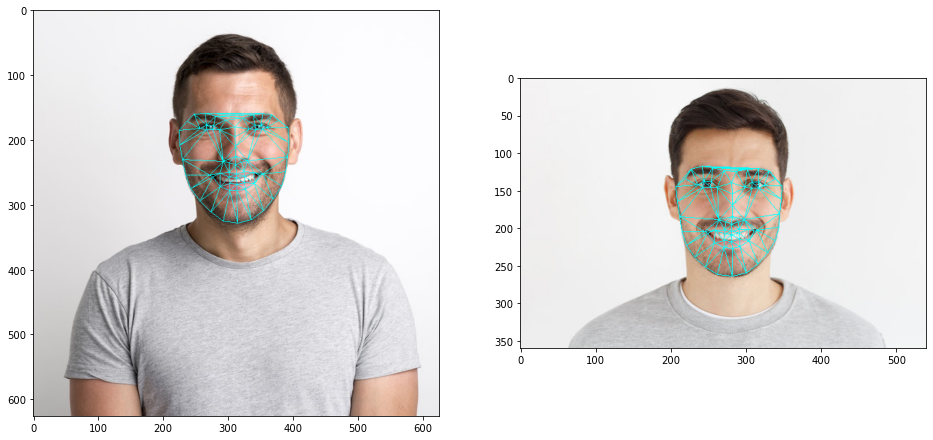

In [7]:
def draw_lines(img, p1, p2, p3, color=(255, 255, 0)):
    cv.line(img, p1, p2, color, 1,  0)
    cv.line(img, p2, p3, color, 1,  0)
    cv.line(img, p3, p1, color, 1,  0)
    return img

def get_vertex_index(vertex, face_landmarks):
    index_list = np.where((face_landmarks == vertex).all(axis=1))
    index = 0
    if index_list[0][0]:
        index = index_list[0][0]
    return index

def construct_triangulation(face_landmarks, img):
    convexhull = cv.convexHull(face_landmarks) 
    rectangles = cv.boundingRect(convexhull)
    subdiv = cv.Subdiv2D(rectangles)
    subdiv.insert(face_landmarks.tolist())
    
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles)
    
    img_triangulation = img.copy()
    triangles_indices = []
    
    for triangle in triangles:
        vertex_1, vertex_2, vertex_3 = (triangle[0], triangle[1]), (triangle[2], triangle[3]), (triangle[4], triangle[5])
        
        img_triangulation = draw_lines(img_triangulation, vertex_1, vertex_2, vertex_3)
        
        index_1 = get_vertex_index(vertex_1, face_landmarks)
        index_2 = get_vertex_index(vertex_2, face_landmarks)
        index_3 = get_vertex_index(vertex_3, face_landmarks)
        
        if (index_1 is not None) and (index_2 is not None) and (index_3 is not None):
            vertices = [index_1, index_2, index_3]
            triangles_indices.append(vertices)
            
    return img_triangulation, triangles_indices, convexhull

img_triangulation_1, triangles_indices_1, convexhull_1 = construct_triangulation(face_landmarks_1, img_1)
img_triangulation_2, triangles_indices_2, convexhull_2 = construct_triangulation(face_landmarks_2, img_2)

show_images([img_triangulation_1, img_triangulation_2])

### Face swap

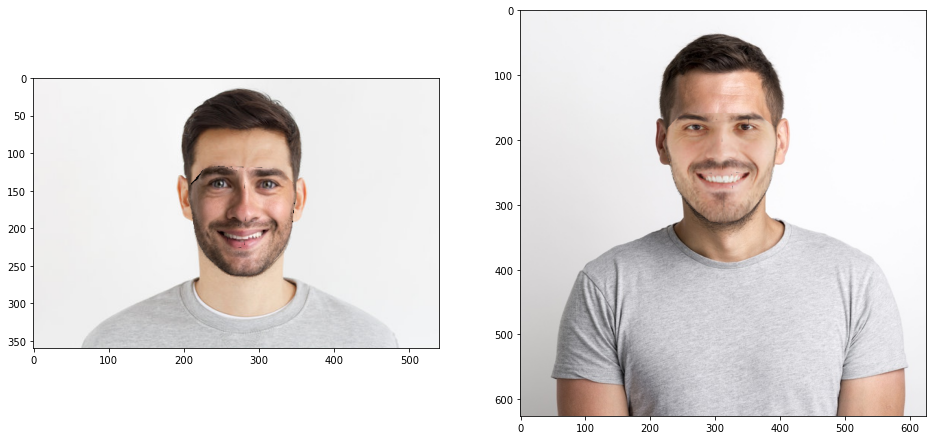

In [8]:
def get_triangle_coords(index, img, landmarks):
    p_1, p_2, p_3 = landmarks[index[0]], landmarks[index[1]], landmarks[index[2]]
    vertices = np.array([p_1, p_2, p_3], np.int32)
    (x, y, w, h) = cv.boundingRect(vertices)
    
    triangle = img[y : y + h, x : x + w]
    triangle_mask = np.zeros((h, w), np.uint8)
        
    points = np.array([[p_1[0] - x, p_1[1] - y], [p_2[0] - x, p_2[1] - y], [p_3[0] - x, p_3[1] - y]], np.int32)
    cv.fillConvexPoly(triangle_mask, points, 255)
    
    return points, triangle, triangle_mask, (x, y, w, h)

def new_face_generation(face, body, face_landmarks, body_landmarks, triangles_indices):
    body_h, body_w, body_c = body.shape
    new_face = np.zeros((body_h, body_w, body_c), np.uint8)
    
    face_h, face_w, face_c = face.shape
    face_mask = np.zeros((face_h, face_w), np.uint8)
    
    for index in triangles_indices:
        points_face, triangle, _, _ = get_triangle_coords(index, face, face_landmarks)

        points_body, _, triangle_mask, (x, y, w, h) = get_triangle_coords(index, body, body_landmarks)

        points_face =  np.float32(points_face)
        points_body = np.float32(points_body)
        
        warped_triangle = cv.getAffineTransform(points_face, points_body)
        warped_triangle = cv.warpAffine(triangle, warped_triangle, (w, h))
        dist_triangle = cv.bitwise_and(warped_triangle, warped_triangle, mask=triangle_mask)
        
        new_face_rect_area = new_face[y : y + h, x : x + w]
        new_face_rect_area_gray = cv.cvtColor(new_face_rect_area, cv.COLOR_BGR2GRAY)
        masked_triangle = cv.threshold(new_face_rect_area_gray, 1, 255, cv.THRESH_BINARY_INV)
        dist_triangle = cv.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])
        new_face_rect_area = cv.add(new_face_rect_area, dist_triangle)
        new_face[y : y + h, x : x + w] = new_face_rect_area
    return new_face

def face_swap(face, body, face_landmarks, body_landmarks, triangles_indices, body_convexhull):
    new_face = new_face_generation(face, body, face_landmarks, body_landmarks, triangles_indices)
    
    body_mask = np.zeros_like(cv.cvtColor(body, cv.COLOR_BGR2GRAY))
    head_mask = cv.fillConvexPoly(body_mask, body_convexhull, 255)
    body_mask = cv.bitwise_not(head_mask)

    body_maskless = cv.bitwise_and(body, body, mask=body_mask)
    result = cv.add(body_maskless, new_face)

    return result
    
swap_1_2 = face_swap(img_1, img_2, face_landmarks_1, face_landmarks_2, triangles_indices_1, convexhull_2)
swap_2_1 = face_swap(img_2, img_1, face_landmarks_2, face_landmarks_1, triangles_indices_2, convexhull_1)

show_images([swap_1_2, swap_2_1])

# Task 2

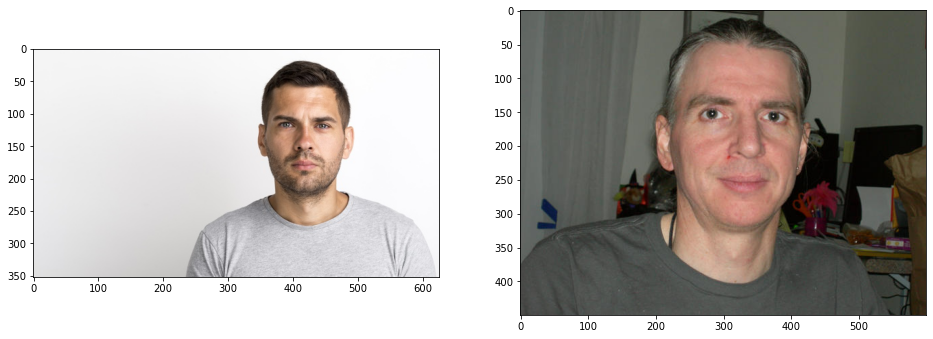

In [9]:
img_1 = cv.imread("assets/img_3.jpeg")
img_2 = cv.imread("assets/img_4.jpeg")
img_gray_1 = cv.cvtColor(img_1, cv.COLOR_BGR2GRAY)
img_gray_2 = cv.cvtColor(img_2, cv.COLOR_BGR2GRAY)

show_images([img_1, img_2])

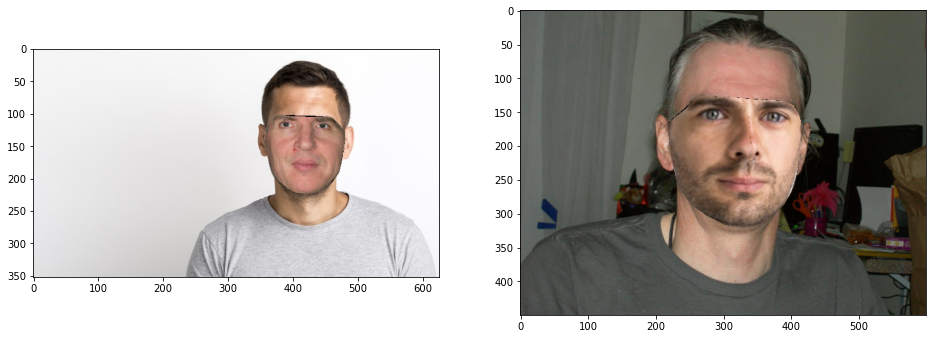

In [10]:
img_bbox_1, faces_1 = detect_bboxes(img_1, img_gray_1) 
img_bbox_2, faces_2 = detect_bboxes(img_2, img_gray_2) 
img_landmark_1, points_list_1 = detect_landmarks(img_bbox_1, img_gray_1, faces_1)
img_landmark_2, points_list_2 = detect_landmarks(img_bbox_2, img_gray_2, faces_2)
face_landmarks_1 = points_list_1[0]
face_landmarks_2 = points_list_2[0]
img_triangulation_1, triangles_indices_1, convexhull_1 = construct_triangulation(face_landmarks_1, img_1)
img_triangulation_2, triangles_indices_2, convexhull_2 = construct_triangulation(face_landmarks_2, img_2)
swap_1_2 = face_swap(img_1, img_2, face_landmarks_1, face_landmarks_2, triangles_indices_1, convexhull_2)
swap_2_1 = face_swap(img_2, img_1, face_landmarks_2, face_landmarks_1, triangles_indices_2, convexhull_1)

show_images([swap_2_1, swap_1_2])

### Blending method: color correction

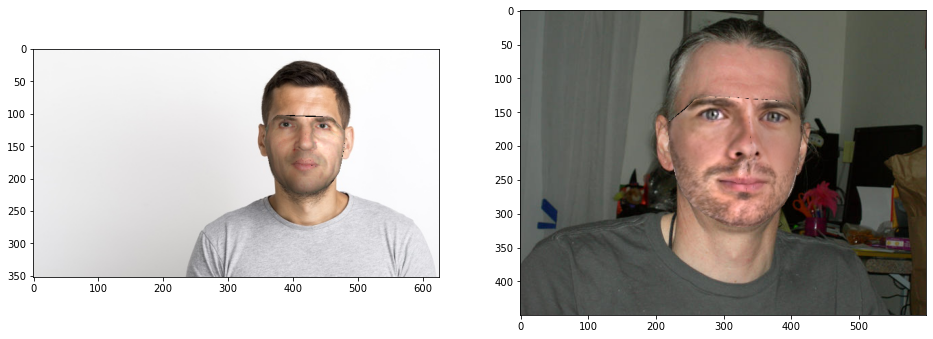

In [13]:
def correct_colours(img1, img2, landmarks):
    blur = 0.75
    left_eye = list(range(42, 48))
    right_eye = list(range(36, 42))

    blur_amount = blur * np.linalg.norm(
        np.mean(landmarks[left_eye], axis=0) -
        np.mean(landmarks[right_eye], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1

    img1_blur = cv.GaussianBlur(img1, (blur_amount, blur_amount), 0)
    img2_blur = cv.GaussianBlur(img2, (blur_amount, blur_amount), 0)

    img2_blur = img2_blur.astype(int)
    img2_blur += 128 * (img2_blur <= 1)

    result = img2.astype(np.float64) * img1_blur.astype(np.float64) / img2_blur.astype(np.float64)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

def face_swap_color_correction (face, body, face_landmarks, body_landmarks, triangles_indices, body_convexhull):
    new_face = new_face_generation(face, body, face_landmarks, body_landmarks, triangles_indices)
    
    body_mask = np.zeros_like(cv.cvtColor(body, cv.COLOR_BGR2GRAY))
    head_mask = cv.fillConvexPoly(body_mask, body_convexhull, 255)
    body_mask = cv.bitwise_not(head_mask)
    
    prev_face = cv.bitwise_and(body, body, mask=head_mask)
    new_face = correct_colours(prev_face, new_face, body_landmarks)

    body_maskless = cv.bitwise_and(body, body, mask=body_mask)
    result = cv.add(body_maskless, new_face)

    return result
    
swap_1_2 = face_swap_color_correction(img_1, img_2, face_landmarks_1, face_landmarks_2, triangles_indices_1, convexhull_2)
swap_2_1 = face_swap_color_correction(img_2, img_1, face_landmarks_2, face_landmarks_1, triangles_indices_2, convexhull_1)

show_images([swap_2_1, swap_1_2])

### Blending method: color correction + Poisson blending

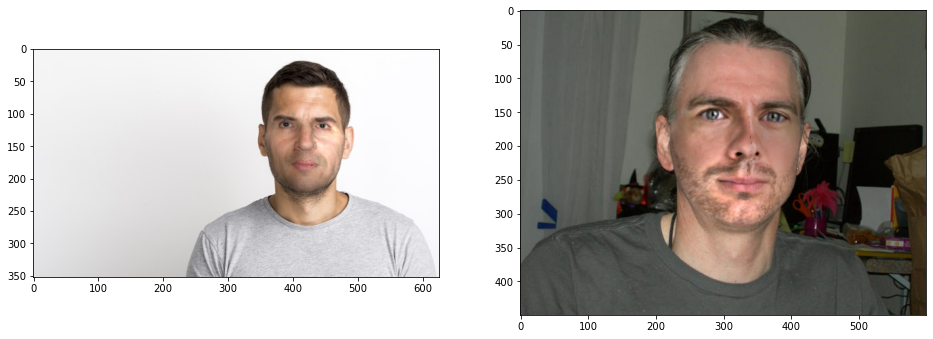

In [14]:
def face_swap_blend (face, body, face_landmarks, body_landmarks, triangles_indices, body_convexhull):
    new_face = new_face_generation(face, body, face_landmarks, body_landmarks, triangles_indices)
    
    body_mask = np.zeros_like(cv.cvtColor(body, cv.COLOR_BGR2GRAY))
    head_mask = cv.fillConvexPoly(body_mask, body_convexhull, 255)
    body_mask = cv.bitwise_not(head_mask)
    
    prev_face = cv.bitwise_and(body, body, mask=head_mask)
    new_face = correct_colours(prev_face, new_face, body_landmarks)

    body_maskless = cv.bitwise_and(body, body, mask=body_mask)
    result = cv.add(body_maskless, new_face)
    
    (x, y, w, h) = cv.boundingRect(body_convexhull)
    center = (int((x + x + w) / 2), int((y + y + h) / 2))

    seamlessclone = cv.seamlessClone(result, body, head_mask, center, cv.NORMAL_CLONE)

    return seamlessclone

swap_1_2 = face_swap_blend(img_1, img_2, face_landmarks_1, face_landmarks_2, triangles_indices_1, convexhull_2)
swap_2_1 = face_swap_blend(img_2, img_1, face_landmarks_2, face_landmarks_1, triangles_indices_2, convexhull_1)

show_images([swap_2_1, swap_1_2])